2. Utilizarem métodos estatísticos para mostrar que o PowerCap aumento o tempo de execução em cada benchmark estudado.

In [1]:
import seaborn as sea
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import KernelDensity
import numpy as py
from scipy import stats
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
file_name = '../measurements_python.csv'
df = pd.read_csv(file_name)

print("BASIC STATS")
print("###### First few rows of the dataset:")
print(df.head())

print("\n\n ###### Basic statistics of the dataset:")
print(df.describe())

print("\n\n ###### Missing values in each column:")
print(df.isnull().sum())

print("\n\n ###### Data types of each column:")
print(df.dtypes)

BASIC STATS
###### First few rows of the dataset:
  Language     Program  PowerLimit     Package        Core GPU DRAM   Time  \
0   Python   chameleon          -1  416.231750  369.447876           17751   
1   Python   chameleon          -1  406.150635  362.666504           17516   
2   Python   chameleon          -1  403.458496  360.269714           17474   
3   Python   chameleon          -1  406.172363  362.136658           17466   
4   Python   chameleon          -1  404.590515  363.036011           17408   

   Temperature  Memory  
0         53.6   43820  
1         54.0   43780  
2         53.6   43796  
3         52.4   43532  
4         53.3   43700  


 ###### Basic statistics of the dataset:
       PowerLimit        Package           Core           Time  Temperature  \
count  600.000000     600.000000     600.000000     600.000000   600.000000   
mean    34.833333     190.231317      75.497931   43608.453333    49.251833   
std     39.446998   10613.894034   10620.006074   7

In [3]:
# drop unnecessary columns because we are only interested in analyzing the correlation between power limit and time
df = df[['Program', 'PowerLimit', 'Time']]

df.head()

,Program,PowerLimit,Time
0,chameleon,-1,17751
1,chameleon,-1,17516
2,chameleon,-1,17474
3,chameleon,-1,17466
4,chameleon,-1,17408


In [4]:
print(df.groupby("Program")[["PowerLimit", "Time"]].describe())

                 PowerLimit                                              \
                      count       mean        std  min  25%   50%   75%   
Program                                                                   
 2to3                  60.0  34.833333  39.746726 -1.0  5.0  22.5  45.0   
 async_tree            60.0  34.833333  39.746726 -1.0  5.0  22.5  45.0   
 chameleon             60.0  34.833333  39.746726 -1.0  5.0  22.5  45.0   
 django_template       60.0  34.833333  39.746726 -1.0  5.0  22.5  45.0   
 docutils              60.0  34.833333  39.746726 -1.0  5.0  22.5  45.0   
 html5lib              60.0  34.833333  39.746726 -1.0  5.0  22.5  45.0   
 json_dumps            60.0  34.833333  39.746726 -1.0  5.0  22.5  45.0   
 nbody                 60.0  34.833333  39.746726 -1.0  5.0  22.5  45.0   
 pidigits              60.0  34.833333  39.746726 -1.0  5.0  22.5  45.0   
 tornado_http          60.0  34.833333  39.746726 -1.0  5.0  22.5  45.0   

                        

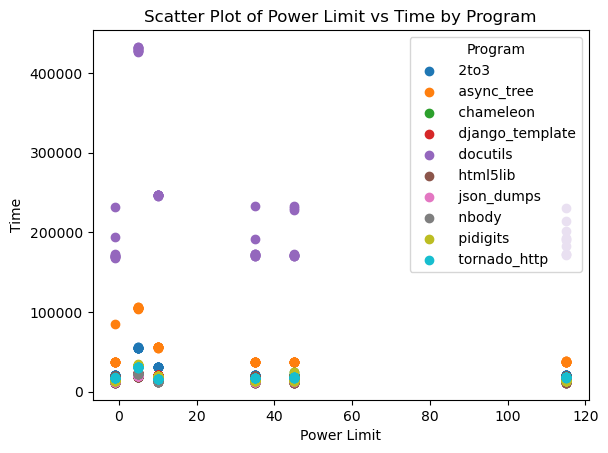

In [5]:
# Create scatter plots for each group
groups = df.groupby('Program')


for name, group in groups:
    plt.scatter(group['PowerLimit'], group['Time'], label=name)

plt.xlabel('Power Limit')
plt.ylabel('Time')
plt.title('Scatter Plot of Power Limit vs Time by Program')
plt.legend(title='Program')
plt.show()


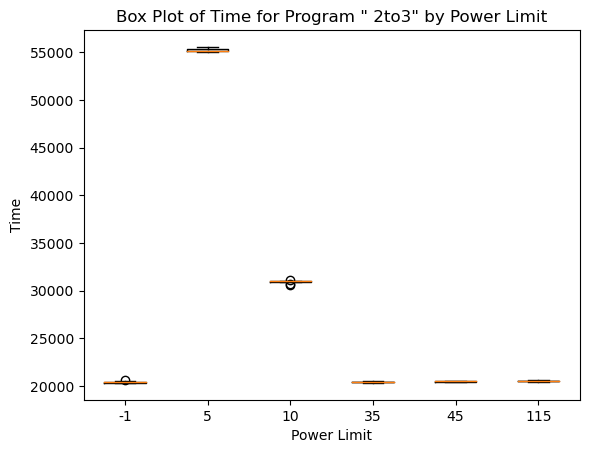

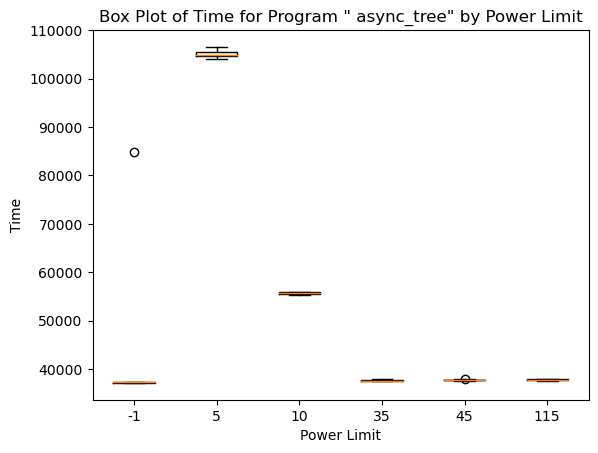

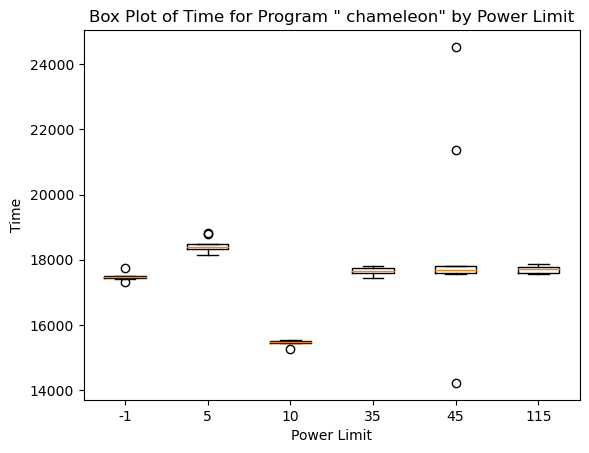

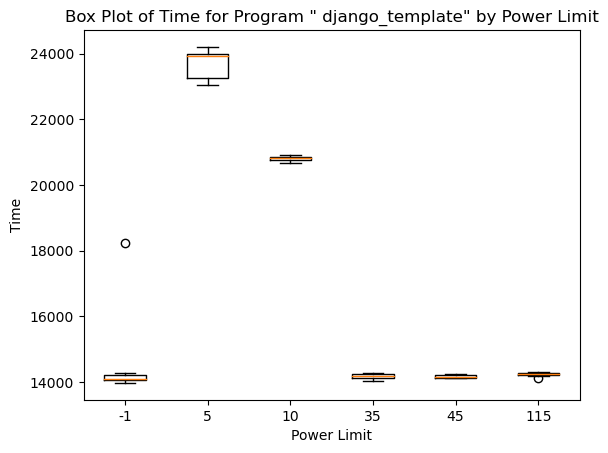

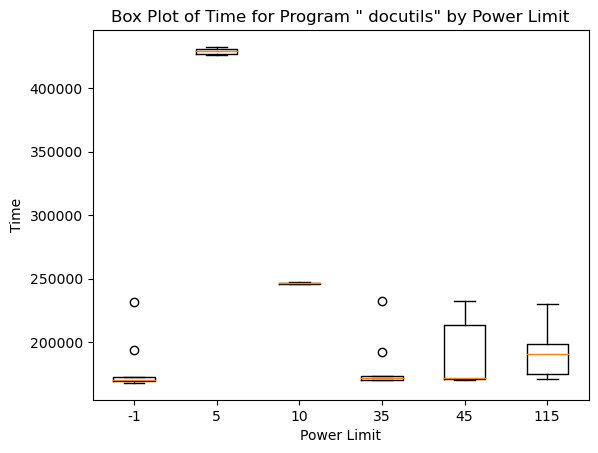

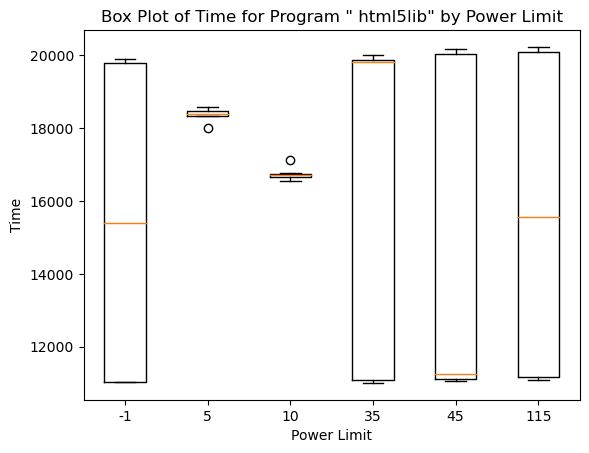

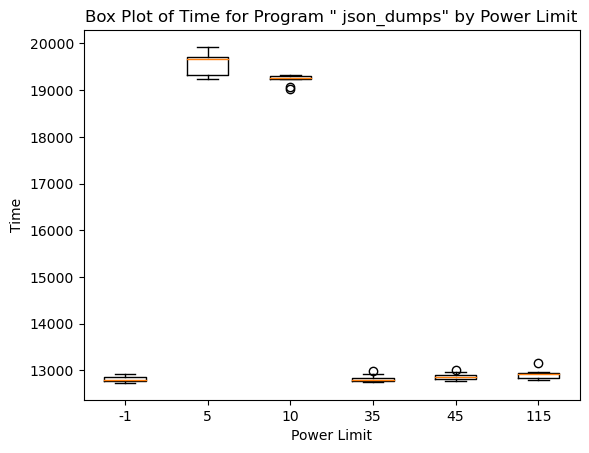

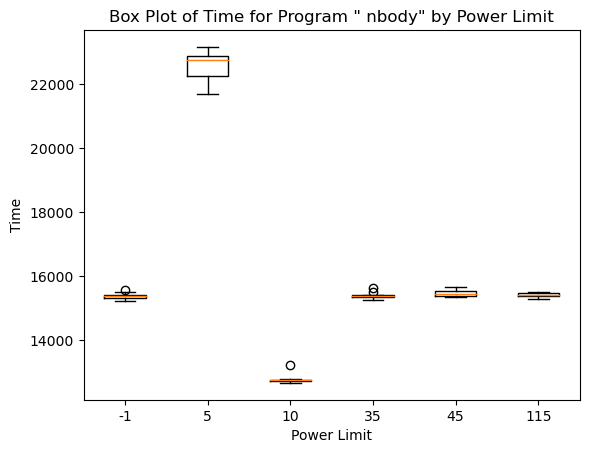

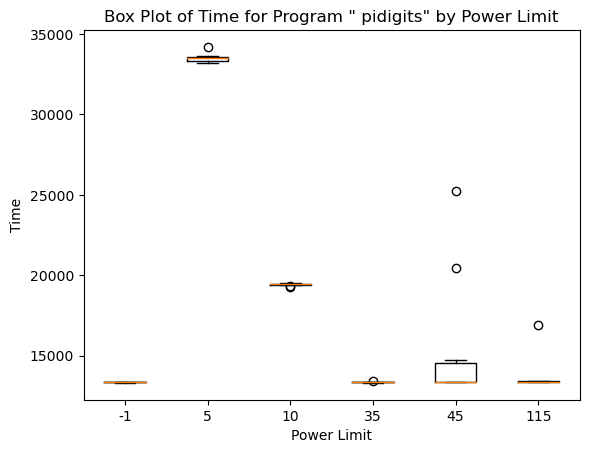

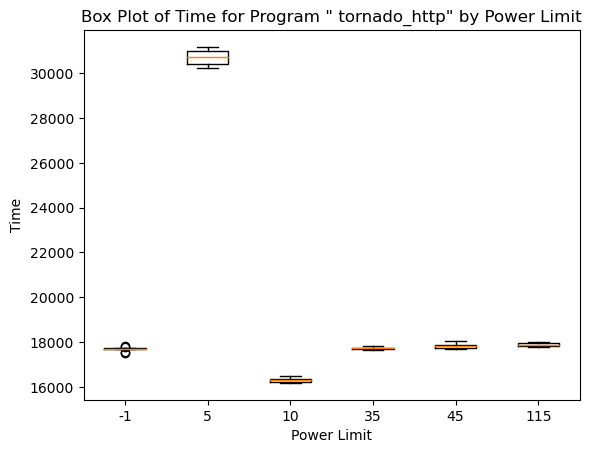

In [6]:

# Iterate over each program group

def show_box_plot(groups):
    for name, program_group in groups:
        # Group the program group by power limit
        power_groups = program_group.groupby('PowerLimit')
        
        # Create an empty list to store the data for each power limit
        data = []
        
        # Extract data for each power limit and store it in the list
        for power, power_group in power_groups:
            data.append(power_group['Time'])
        
        
        # Create a box plot for each power limit for the current program
        plt.boxplot(data, labels=power_groups.groups.keys())
        plt.xlabel('Power Limit')
        plt.ylabel('Time')
        plt.title(f'Box Plot of Time for Program "{name}" by Power Limit')
        plt.show()

show_box_plot(groups)

In [7]:
## REMOVE OUTLIERS in each group (grouped by program and power limit)

grouped_df = df.groupby(['Program', 'PowerLimit'])

def remove_outliers(group):
    Q1 = group['Time'].quantile(0.25)
    Q3 = group['Time'].quantile(0.75)
    IQR = Q3 - Q1
    mask = (group['Time'] >= (Q1 - 1.5 * IQR)) & (group['Time'] <= (Q3 + 1.5 * IQR))
    return group[mask]


cleaned_df = grouped_df.apply(remove_outliers).reset_index(drop=True)
cleaned_df2 = cleaned_df.groupby(['Program'])
print(cleaned_df.count())


Program       558
PowerLimit    558
Time          558
dtype: int64


                  PowerLimit  Time
Program                           
 2to3                     60    60
 async_tree               60    60
 chameleon                60    60
 django_template          60    60
 docutils                 60    60
 html5lib                 60    60
 json_dumps               60    60
 nbody                    60    60
 pidigits                 60    60
 tornado_http             60    60
Program       558
PowerLimit    558
Time          558
dtype: int64
                  PowerLimit  Time
Program                           
 2to3                     56    56
 async_tree               58    58
 chameleon                52    52
 django_template          58    58
 docutils                 56    56
 html5lib                 58    58
 json_dumps               55    55
 nbody                    56    56
 pidigits                 53    53
 tornado_http             56    56


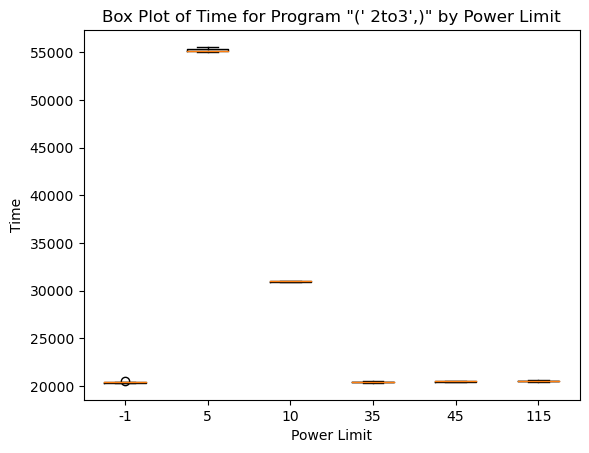

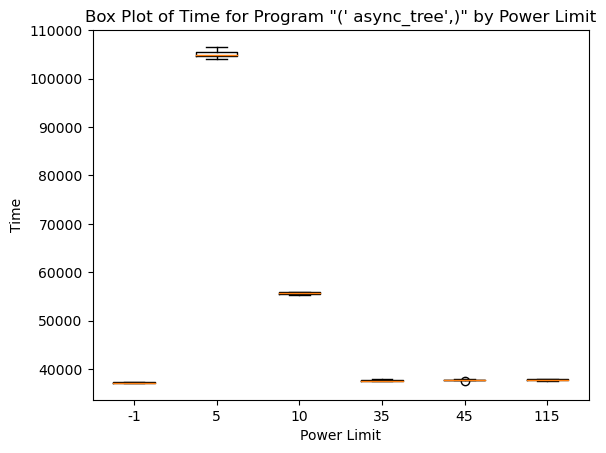

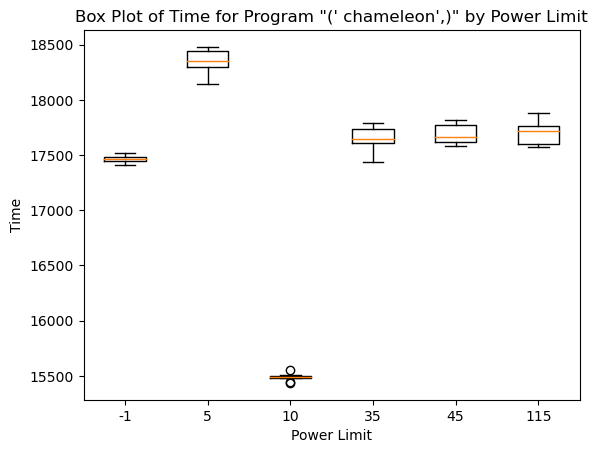

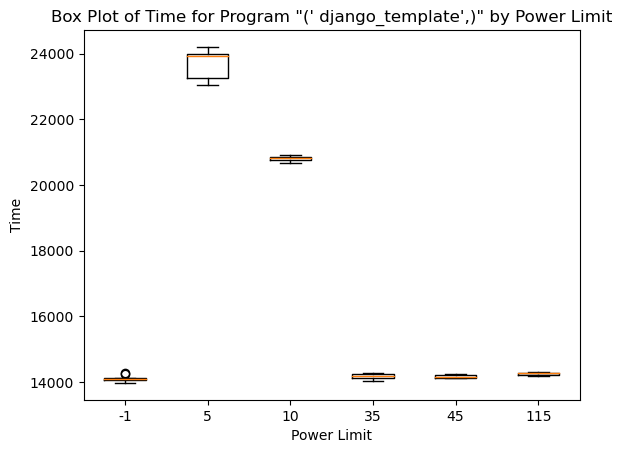

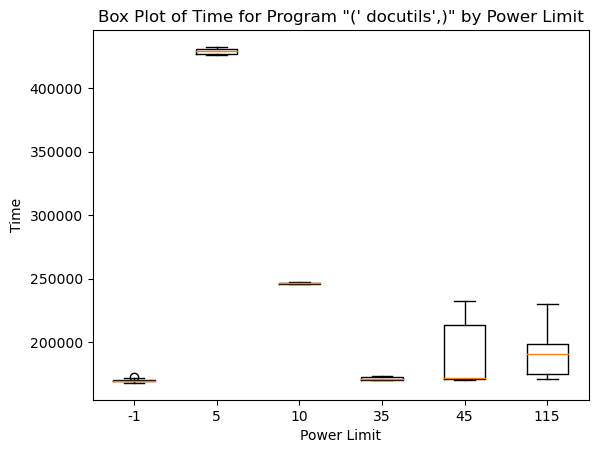

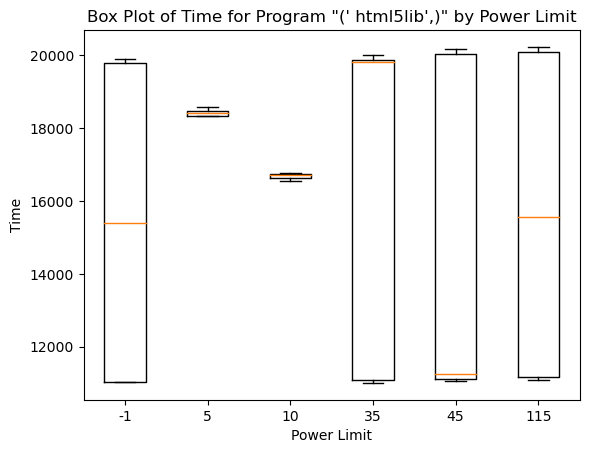

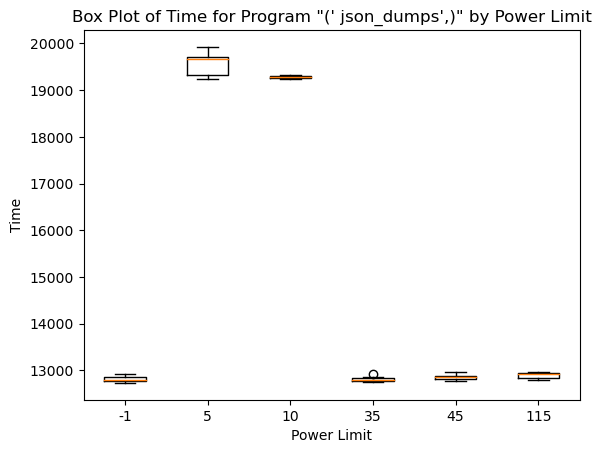

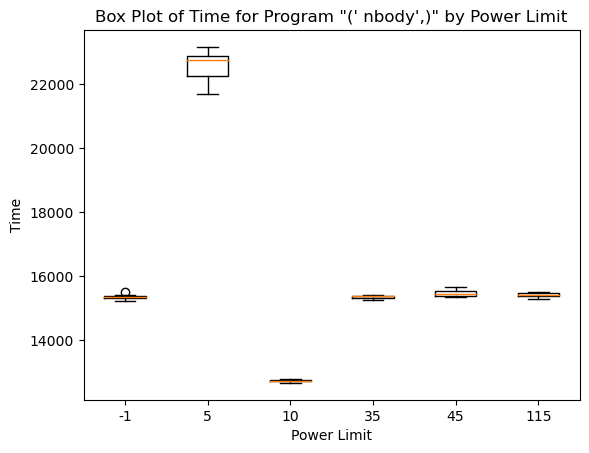

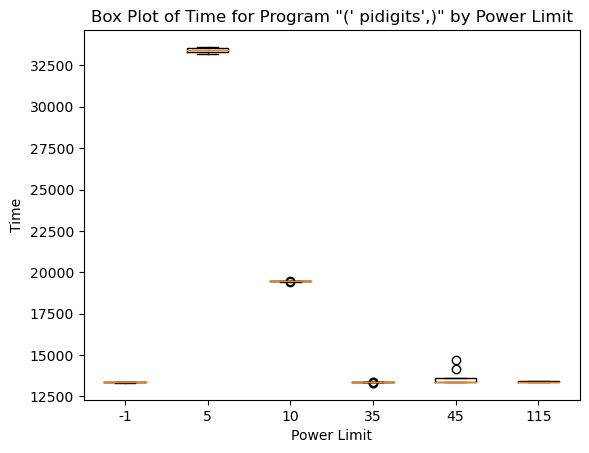

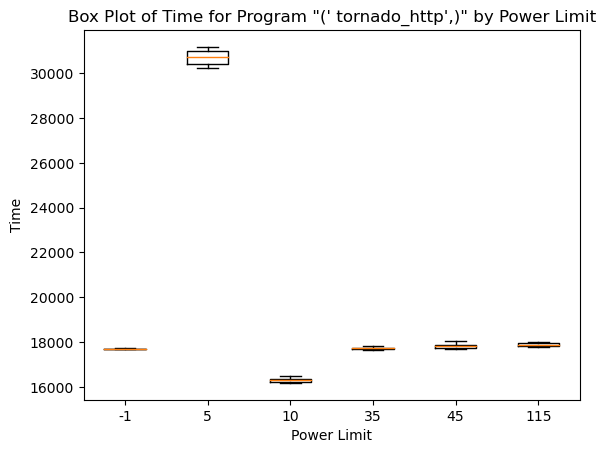

In [8]:
print(groups.count())
print(cleaned_df.count())
print(cleaned_df2.count())

show_box_plot(cleaned_df2)

In [9]:
def calculate_correlations(group):
    # Pearson correlation
    pearson_corr, pearson_p = stats.pearsonr(group['Time'], group['PowerLimit'])
    
    # Spearman correlation
    spearman_corr, spearman_p = stats.spearmanr(group['Time'], group['PowerLimit'])
    
    # Kendall Tau correlation
    kendall_corr, kendall_p = stats.kendalltau(group['Time'], group['PowerLimit'])
    
    # Return results in a DataFrame format for easier concatenation
    return pd.DataFrame({
        'Program': [group['Program'].iloc[0]],
        'Pearson': [pearson_corr],
        'Pearson_p': [pearson_p],
        'Spearman': [spearman_corr],
        'Spearman_p': [spearman_p],
        'Kendall': [kendall_corr],
        'Kendall_p': [kendall_p]
    })

# Remove rows with PowerLimit = -1 because it has no powercap 
cleaned_df3 = cleaned_df[cleaned_df['PowerLimit'] != -1]

#print(cleaned_df3.groupby(['Program',"PowerLimit"]).count())
# Group by 'Program' and apply the correlation calculation function
correlation_results = cleaned_df3.groupby('Program').apply(calculate_correlations).reset_index(drop=True)

# Print the correlation results
print(correlation_results)

            Program   Pearson     Pearson_p  Spearman    Spearman_p   Kendall  \
0              2to3 -0.616118  4.021078e-06 -0.582304  1.756540e-05 -0.405552   
1        async_tree -0.595957  6.245252e-06 -0.700943  2.044407e-08 -0.520680   
2         chameleon  0.275636  7.014252e-02 -0.103298  5.046041e-01 -0.005855   
3   django_template -0.698508  2.399410e-08 -0.715324  7.679740e-09 -0.540913   
4          docutils -0.560357  3.445283e-05 -0.699683  3.141266e-08 -0.526158   
5          html5lib -0.195458  1.830698e-01 -0.008254  9.555986e-01 -0.018649   
6        json_dumps -0.711190  4.373119e-08 -0.655419  1.029029e-06 -0.464190   
7             nbody -0.302152  3.899960e-02 -0.193715  1.920014e-01 -0.068648   
8          pidigits -0.616709  1.063978e-05 -0.698535  1.903500e-07 -0.529961   
9      tornado_http -0.401643  3.839756e-03 -0.048020  7.405291e-01  0.095772   

      Kendall_p  
0  2.084105e-04  
1  1.086152e-06  
2  9.587026e-01  
3  4.174748e-07  
4  1.093221e-06  


### Correlation Analysis between `PowerLimit` &&  `Time`

Important Note: values with powerlimit -1 were removed because it means no powerlimit was apllied.

Here's the interpretation for each program in the provided output:


Here's the interpretation for each program in the provided output:

### Program: 2to3

1. **Pearson**: -0.616118, p-value = 4.021078e-06
   - Moderate negative linear relationship, statistically significant.
2. **Spearman**: -0.582304, p-value = 1.756540e-05
   - Moderate negative monotonic relationship, statistically significant.
3. **Kendall**: -0.405552, p-value = 2.084105e-04
   - Moderate negative association, statistically significant.

### Program: async_tree

1. **Pearson**: -0.595957, p-value = 6.245252e-06
   - Moderate negative linear relationship, statistically significant.
2. **Spearman**: -0.700943, p-value = 2.044407e-08
   - Strong negative monotonic relationship, statistically significant.
3. **Kendall**: -0.520680, p-value = 1.086152e-06
   - Moderate negative association, statistically significant.

### Program: chameleon

1. **Pearson**: 0.275636, p-value = 7.014252e-02
   - Weak positive linear relationship, not statistically significant.
2. **Spearman**: -0.103298, p-value = 5.046041e-01
   - No significant monotonic relationship.
3. **Kendall**: -0.005855, p-value = 9.587026e-01
   - No significant association.

### Program: django_template

1. **Pearson**: -0.698508, p-value = 2.399410e-08
   - Strong negative linear relationship, statistically significant.
2. **Spearman**: -0.715324, p-value = 7.679740e-09
   - Strong negative monotonic relationship, statistically significant.
3. **Kendall**: -0.540913, p-value = 4.174748e-07
   - Moderate negative association, statistically significant.

### Program: docutils

1. **Pearson**: -0.560357, p-value = 3.445283e-05
   - Moderate negative linear relationship, statistically significant.
2. **Spearman**: -0.699683, p-value = 3.141266e-08
   - Strong negative monotonic relationship, statistically significant.
3. **Kendall**: -0.526158, p-value = 1.093221e-06
   - Moderate negative association, statistically significant.

### Program: html5lib

1. **Pearson**: -0.195458, p-value = 1.830698e-01
   - Weak negative linear relationship, not statistically significant.
2. **Spearman**: -0.008254, p-value = 9.555986e-01
   - No significant monotonic relationship.
3. **Kendall**: -0.018649, p-value = 8.628594e-01
   - No significant association.

### Program: json_dumps

1. **Pearson**: -0.711190, p-value = 4.373119e-08
   - Strong negative linear relationship, statistically significant.
2. **Spearman**: -0.655419, p-value = 1.029029e-06
   - Strong negative monotonic relationship, statistically significant.
3. **Kendall**: -0.464190, p-value = 3.270944e-05
   - Moderate negative association, statistically significant.

### Program: nbody

1. **Pearson**: -0.302152, p-value = 3.899960e-02
   - Weak negative linear relationship, statistically significant.
2. **Spearman**: -0.193715, p-value = 1.920014e-01
   - No significant monotonic relationship.
3. **Kendall**: -0.068648, p-value = 5.295613e-01
   - No significant association.

### Program: pidigits

1. **Pearson**: -0.616709, p-value = 1.063978e-05
   - Moderate negative linear relationship, statistically significant.
2. **Spearman**: -0.698535, p-value = 1.903500e-07
   - Strong negative monotonic relationship, statistically significant.
3. **Kendall**: -0.529961, p-value = 3.894196e-06
   - Moderate negative association, statistically significant.

### Program: tornado_http

1. **Pearson**: -0.401643, p-value = 3.839756e-03
   - Weak negative linear relationship, statistically significant.
2. **Spearman**: -0.048020, p-value = 7.405291e-01
   - No significant monotonic relationship.
3. **Kendall**: 0.095772, p-value = 3.645534e-01
   - No significant association.

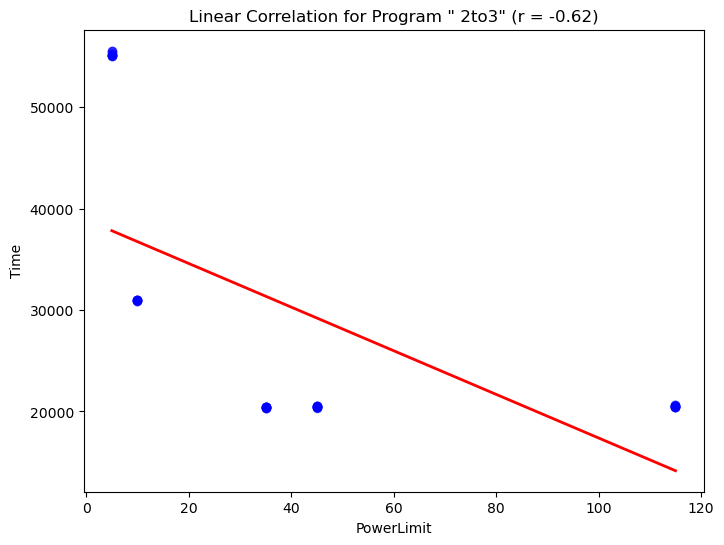

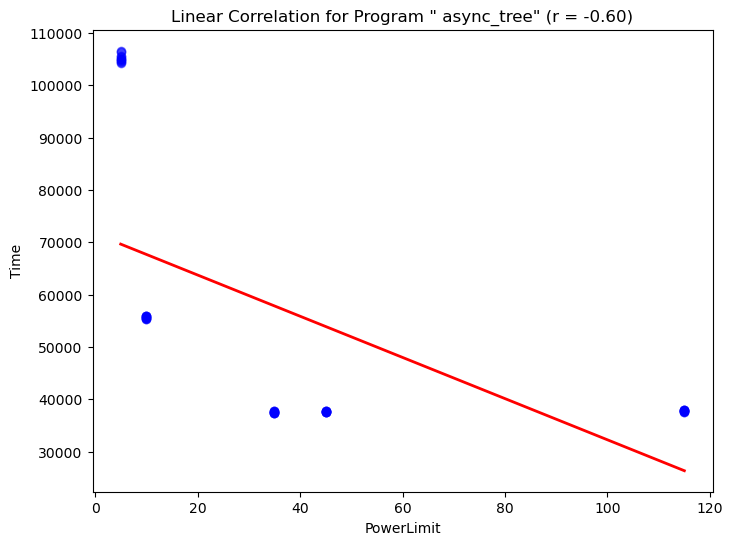

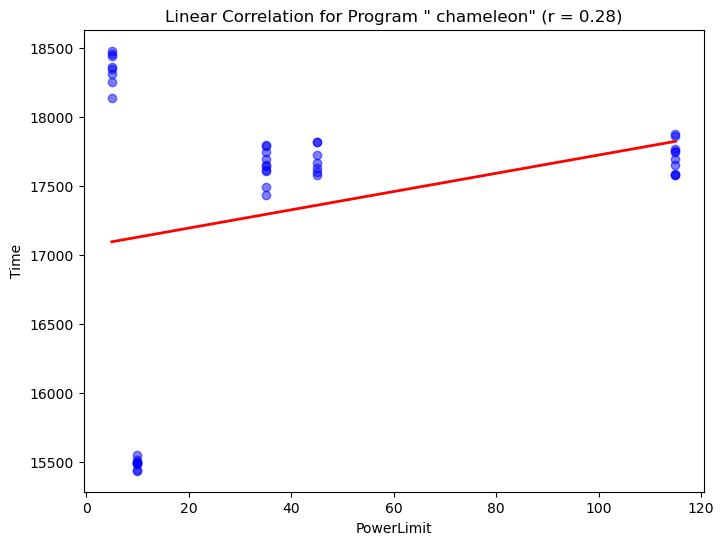

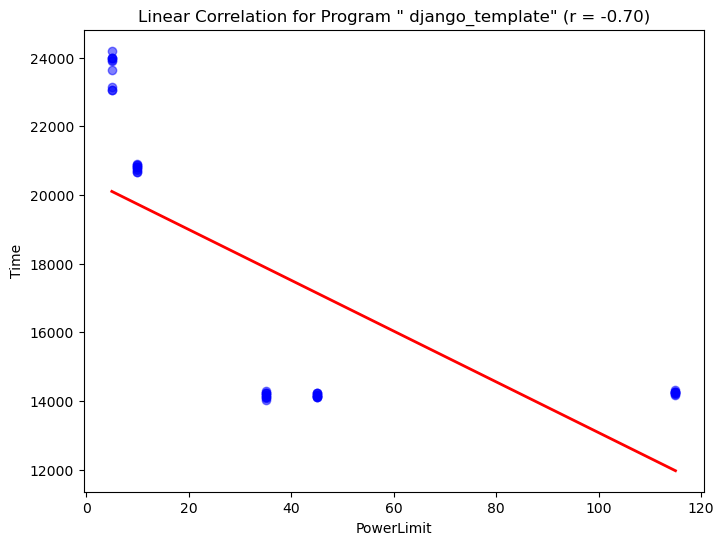

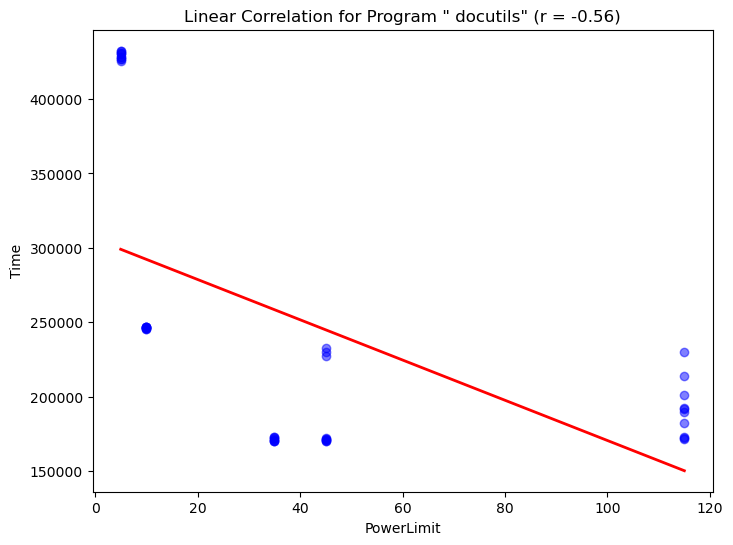

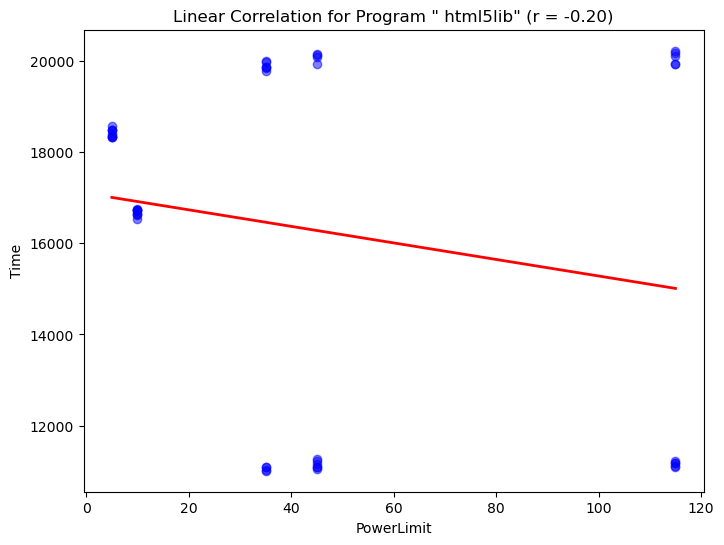

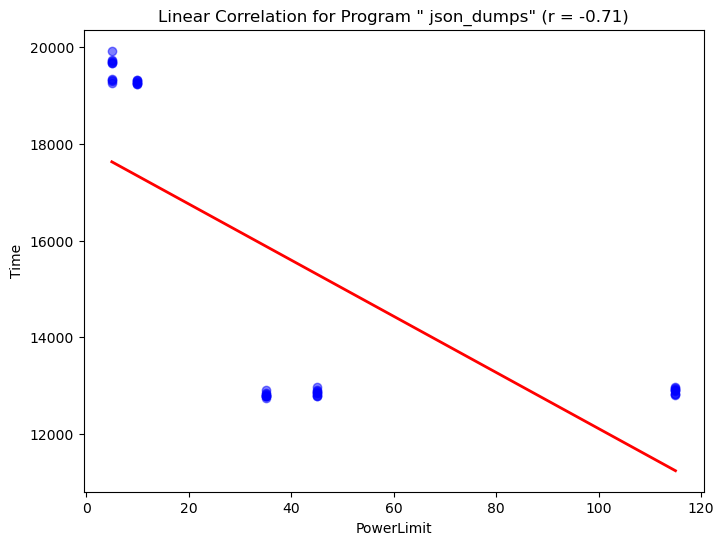

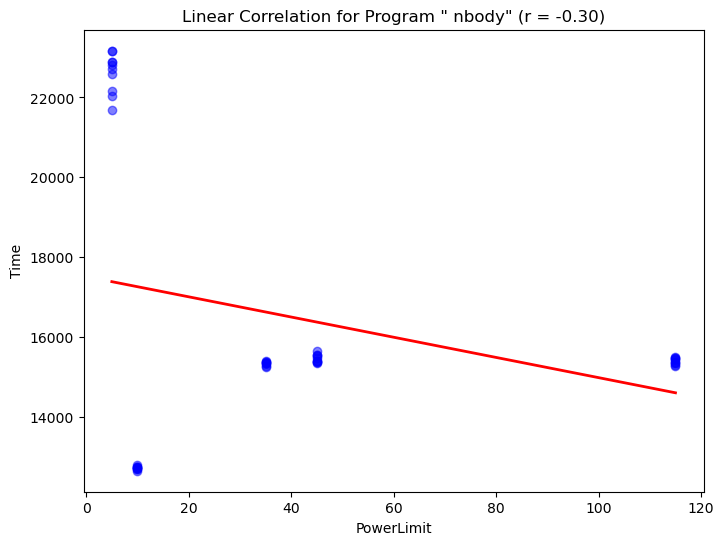

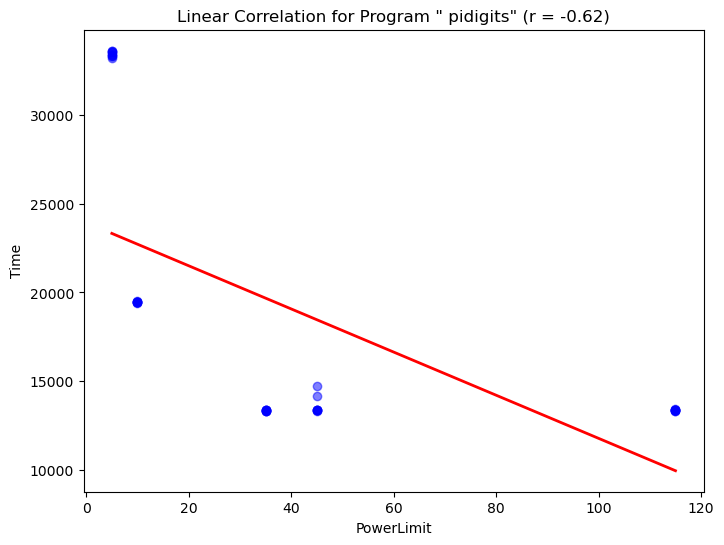

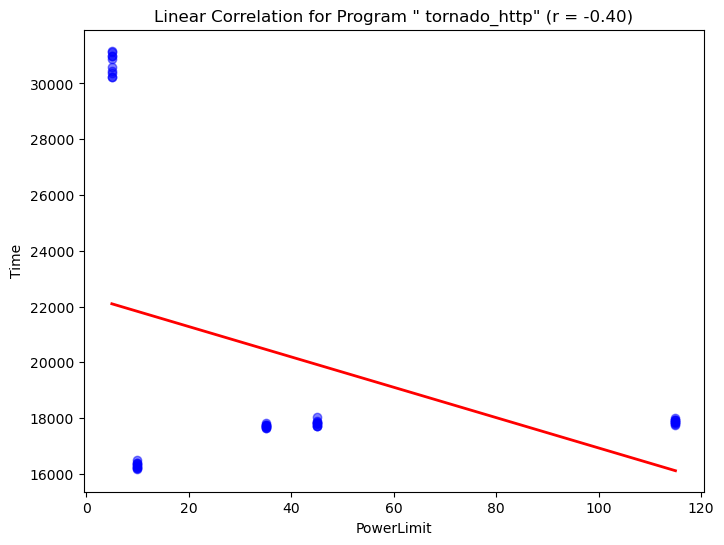

In [10]:
def show_correlation_plot(groups):
    for name, program_group in groups:
        # Calculate correlation for the current program group
        pearson_corr, pearson_p = stats.pearsonr(program_group['Time'], program_group['PowerLimit'])

        # Create the scatter plot
        plt.figure(figsize=(8, 6))
        plt.scatter(program_group['PowerLimit'], program_group['Time'], color='blue', alpha=0.5)

        # Add the linear regression line
        slope, intercept, r_value, p_value, std_err = stats.linregress(program_group['PowerLimit'], program_group['Time'])
        plt.plot(program_group['PowerLimit'], slope * program_group['PowerLimit'] + intercept, color='red', linewidth=2)

        plt.xlabel('PowerLimit')
        plt.ylabel('Time')
        plt.title('Linear Correlation for Program "{}" (r = {:.2f})'.format(name, pearson_corr))
        plt.show()

# Assuming 'groups' is already defined elsewhere
show_correlation_plot(cleaned_df3.groupby('Program'))

## Conclusion

Overall, the correlation analysis reveals consistent negative relationships between `Time` and `PowerLimit` across various programs. Although in with more intrecsies:

1. **Varied Relationship**: The correlation analysis reveals a diverse range of relationships between the variables Time and PowerLimit across different programs. While some programs exhibit moderate to strong negative correlations, indicating that higher execution times are associated with lower power limits, others show weak or no significant correlations.

2. **Statistical Significance**: The majority of programs display statistically significant correlations between Time and PowerLimit, as evidenced by the low p-values associated with the correlation coefficients. This suggests that the observed relationships are unlikely to have occurred by random chance alone.

3. **Program-Specific Patterns**: Certain programs, such as `django_template` and `json_dumps`, demonstrate strong negative linear correlations between Time and PowerLimit, indicating a consistent decrease in power limit with increasing execution time. On the other hand, programs like `chameleon` and `html5lib` exhibit weak or inverse significant correlations, suggesting that this could be more IO-bound programs than CPU-bound.

4. **Monotonic vs. Linear Relationships**: While some programs show strong negative monotonic relationships between Time and PowerLimit, others display moderate negative linear relationships. This indicates that the associations between the variables may not always follow a linear trend and can vary in their direction and strength.